# Ensemble methods on Titanic 🚢🚢

## Introduction

This exercise is the opportunity to practice ensemble methods on a dataset you have worked with before and that is the Titanic dataset.

Let's start by importing the librairies that we will used in the exercise.

In [1]:
!pip install -q xgboost
!pip install -q s3fs

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# import ensemble methods
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Feature Exploration, Engineering and Cleaning 

1. Import the data using the following link : "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/stacking/titanic.csv" , and display the first lines. Are there any missing values in the dataset?

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


2. What types of variables are present in this dataset? What kind of preprocessing could you run on these variables?

3. Here are some guidelines you can follow to clean the dataset as well as create new variables (feature engineering).

a.  Create a Name_length variable that measures the number of characters in the variable Name for each observations.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24


b. Create a variable Has_Cabin that indicates whether the passenger has a cabin or not.

Hint: [this method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.notna.html#pandas.DataFrame.notna) might be useful 😉

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,False


c. Create a variable FamilySize that gives the size of each passenger's family.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,False,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,True,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,False,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,True,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,False,1


d. Create a variable IsAlone that indicates whether the passenger is traveling on their own.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,False,2,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,True,2,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,False,1,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,True,2,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,False,1,True


h. Extract the title from each passenger in order to create a variable Title.

Hint: You might consider _applying_ a function that calls the [str.split method](https://docs.python.org/3.3/library/stdtypes.html?highlight=split#str.split) 😉

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,False,2,False,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,True,2,False,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,False,1,True,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,True,2,False,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,False,1,True,Mr


i. If some of these titles are equivalent convert them in order to bring them all in the same category.

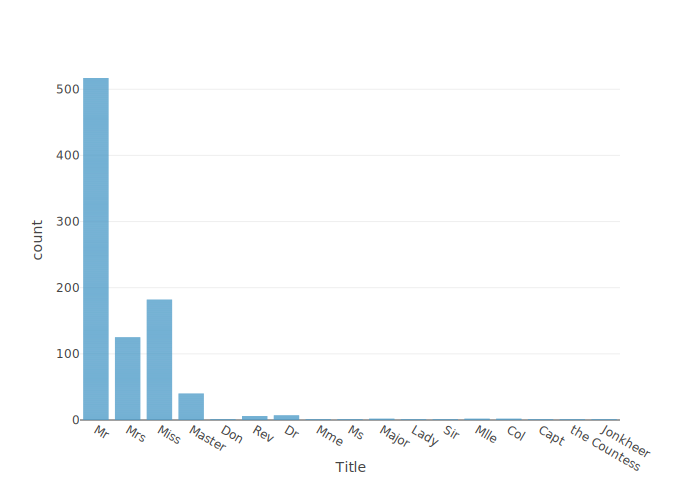

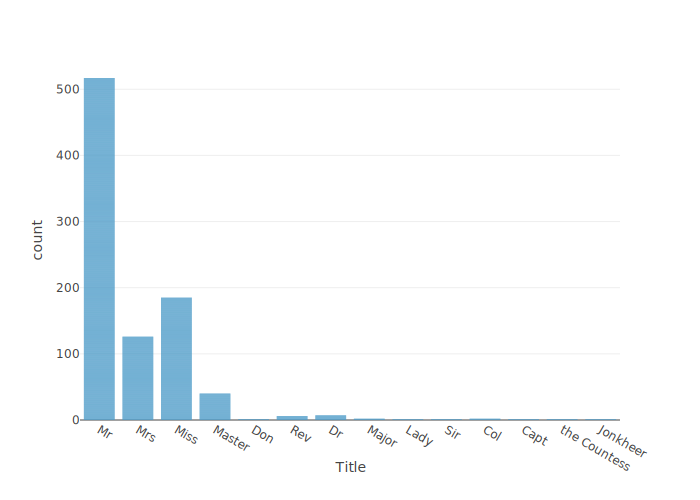

j. Are any of the remaining titles underrepresented among the observations? If it is the case, group them in a unique modality "Rare"

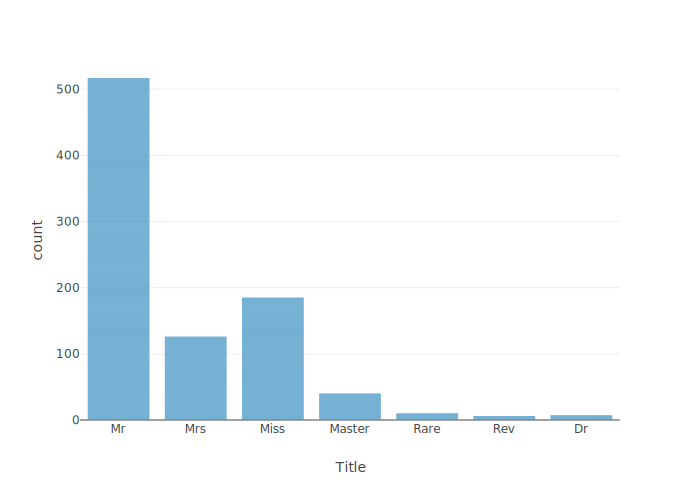

4. Drop the columns 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp' du dataset. Why don't we need these columns for what's next?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Embarked     889 non-null    object 
 7   Name_length  891 non-null    int64  
 8   Has_Cabin    891 non-null    bool   
 9   FamilySize   891 non-null    int64  
 10  IsAlone      891 non-null    bool   
 11  Title        891 non-null    object 
dtypes: bool(2), float64(2), int64(5), object(3)
memory usage: 71.5+ KB


5. Separate the features from the target and split the data between train and test (with random_state = 0)

6. Using the Pipeline and ColumnTransformer, make all the preprocessings at once. Use the [KNN imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to handle the missing values in the numeric variables, and the SimpleImputer for categorical data.

Found numeric features  ['Pclass', 'Age', 'Parch', 'Fare', 'Name_length', 'FamilySize']
Found categorical features  ['Sex', 'Embarked', 'Has_Cabin', 'IsAlone', 'Title']


Performing preprocessings on train set...
     Pclass     Sex   Age  Parch    Fare Embarked  Name_length  Has_Cabin  \
671       1    male  31.0      0  52.000        S           22       True   
417       2  female  18.0      2  13.000        S           29      False   
634       3  female   9.0      2  27.900        S           18      False   
323       2  female  22.0      1  29.000        S           51      False   
379       3    male  19.0      0   7.775        S           27      False   

     FamilySize  IsAlone Title  
671           2    False    Mr  
417           3    False  Miss  
634           6    False  Miss  
323           3    False   Mrs  
379           1     True    Mr  
...Done.
[[-1.54562952  0.08277622 -0.46398808  0.35047578 -0.52725961  0.08547193
   1.          0.          1.          1.          0.          0.
   0.          1.          0.          0.          0.        ]
 [-0.35613584 -0.89456241  2.08699167 -0.37942193  0.23157878  0.72699155
   0.      

### Pearson Correlation Heatmap

7. Produce a figure that contains the correlation table for all the explanatory variables of X_train, what do you think?

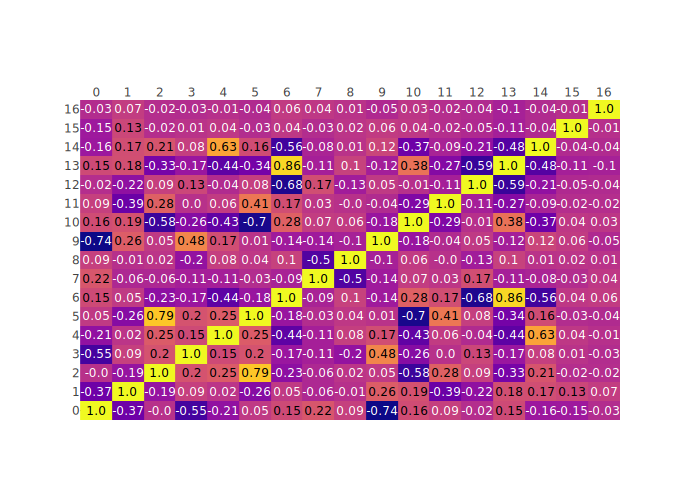

**Correlations between the variables are not very high, we can hope that they will each bring complementary information in order to predict the target variable.**

## Ensembling & Stacking models

Now that we have finished our preprocessing and made sure our data was fit for prediction, let's move on to creating our ensemble models. We'll train different models with different ensembling strategies and store their train and test scores for comparison.

### Random Forest
8. Train a Random Forest by tuning the hyperparameters with a grid search. Which ensemble method is related to random forests?

Evaluate the best model's accuracy on train and test sets. Save the scores into a pandas DataFrame.

Grid search...
{'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 4, 8], 'n_estimators': [10, 20, 40, 60, 80, 100]}
Fitting 3 folds for each of 270 candidates, totalling 810 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 10}
Best validation accuracy :  0.8277919174780162

Accuracy on training set :  0.874251497005988
Accuracy on test set :  0.7892376681614349


,model,accuracy,set
0,random_forest,0.874251,train
1,random_forest,0.789238,test


9. Create your own Bagging of decision tree (with the same hyperparameters as the optimal ones for Random Forest) and check you get compatible performances.

Training Bagging of decision tree...
...Done.
Accuracy on training set :  0.937125748502994
Accuracy on test set :  0.8161434977578476


,model,accuracy,set
0,random_forest,0.874251,train
1,random_forest,0.789238,test
2,bagging_dt,0.937126,train
3,bagging_dt,0.816143,test


10. Train an AdaBoost model by tuning the hyperparameters:
* With a logistic regression as base estimator
* With a decision tree as base estimator

For each model, evaluate the performances on the test set.

Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0], 'n_estimators': [5, 10, 20, 40, 60, 80, 100]}
Fitting 3 folds for each of 56 candidates, totalling 168 fits
...Done.
Best hyperparameters :  {'base_estimator__C': 5.0, 'n_estimators': 60}
Best validation accuracy :  0.8368009264870251

Accuracy on training set :  0.8323353293413174
Accuracy on test set :  0.8026905829596412


,model,accuracy,set
0,random_forest,0.874251,train
1,random_forest,0.789238,test
2,bagging_dt,0.937126,train
3,bagging_dt,0.816143,test
4,adaboost_logreg,0.832335,train
5,adaboost_logreg,0.802691,test


Grid search...
{'base_estimator__max_depth': [8, 10, 12], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 8, 'n_estimators': 8}
Best validation accuracy :  0.7933314480399681

Accuracy on training set :  1.0
Accuracy on test set :  0.8026905829596412


,model,accuracy,set
0,random_forest,0.874251,train
1,random_forest,0.789238,test
2,bagging_dt,0.937126,train
3,bagging_dt,0.816143,test
4,adaboost_logreg,0.832335,train
5,adaboost_logreg,0.802691,test
6,adaboost_dt,1.0,train
7,adaboost_dt,0.802691,test


11. Train scikit-learn's GradientBoosting model (by tuning hyperparameters) and evaluate the performances.

Grid search...
{'max_depth': [8, 10, 12], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 12}
Best validation accuracy :  0.8233278121170499

Accuracy on training set :  0.9356287425149701
Accuracy on test set :  0.8475336322869955


,model,accuracy,set
0,random_forest,0.874251,train
1,random_forest,0.789238,test
2,bagging_dt,0.937126,train
3,bagging_dt,0.816143,test
4,adaboost_logreg,0.832335,train
5,adaboost_logreg,0.802691,test
6,adaboost_dt,1.0,train
7,adaboost_dt,0.802691,test
8,gradient_boost,0.935629,train
9,gradient_boost,0.847534,test


12. Train an XGBoost model (by tuning hyperparameters). Do you get better or similar results compared to scikit-learn's GradientBoosting?

Grid search...
{'max_depth': [4, 6, 8, 10], 'min_child_weight': [1, 2, 4, 6, 8], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 120 candidates, totalling 360 fits
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 6}
Best validation accuracy :  0.8248360468091409

Accuracy on training set :  0.8727544910179641
Accuracy on test set :  0.8251121076233184


,model,accuracy,set
0,random_forest,0.874251,train
1,random_forest,0.789238,test
2,bagging_dt,0.937126,train
3,bagging_dt,0.816143,test
4,adaboost_logreg,0.832335,train
5,adaboost_logreg,0.802691,test
6,adaboost_dt,1.0,train
7,adaboost_dt,0.802691,test
8,gradient_boost,0.935629,train
9,gradient_boost,0.847534,test


13. Compare all the models' performances in a bar chart and conclude. Which model is the best?

Hint: the option `barmode` in plotly's `px.bar()` might be useful 😇

,model,accuracy,set
6,adaboost_dt,1.0,train
2,bagging_dt,0.937126,train
8,gradient_boost,0.935629,train
0,random_forest,0.874251,train
10,xgboost,0.872754,train
4,adaboost_logreg,0.832335,train
9,gradient_boost,0.847534,test
11,xgboost,0.825112,test
3,bagging_dt,0.816143,test
5,adaboost_logreg,0.802691,test


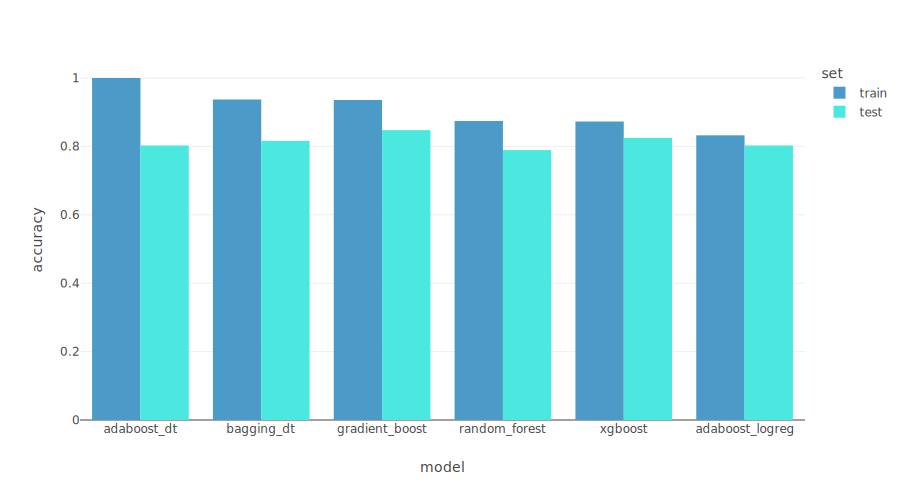